In [1]:
import numpy as np
import csv
import itertools
import matplotlib
%matplotlib inline
import seaborn as sb
from matplotlib import pyplot as plt
from cycler import cycler
import datetime
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pwlf


In [2]:
import sys

In [3]:
sys.executable


'/usr/local/opt/python/bin/python3.7'

In [4]:
matplotlib.__version__

'3.2.1'

In [5]:
def Float(x):
    try:
        rtn = float(x)
    except:
        rtn = float('NaN')
    return rtn



## JHU data

In [6]:
def get_data(jhu_file):
    dat = []
    with open(jhu_file, newline='') as csvfile:
        myreader = csv.reader(csvfile, delimiter=',')
        popdat = []
        i = 0
        for row in myreader:
            if i != 0:
                poplist = []
                j = 0
                for elt in row:
                    if j >= 4:
                        poplist.append(int(elt))
                    elif j == 0:
                        poplist.append(elt)
                    elif j == 1:
                        poplist[0]=(elt,poplist[0])
                    j = j+1
                popdat.append(poplist)
            else:
                popdat.append(row)
            # print(popdat[i])
            i = i + 1;
    popdat0=['date']
    for elt in popdat[0][4:]:
        popdat0.append(elt)
    popdat[0] = popdat0
    totals = np.zeros(len(popdat[0])-1,dtype=int)
    for row in popdat[1:]:
        totals = totals + np.array(row[1:])
    totals = list(np.asarray(totals))
    # print(totals)
    popkeyed = {poplist[0]: poplist[1:] for poplist in popdat}
    popkeyed.update({'dates':popdat[0][1:]})
    popkeyed.update({('World',''):totals})
    # popkeyed[('Canada', 'Ontario')]
    # popkeyed['dates']
    return popkeyed

In [7]:
base = '../covid-19-JH/csse_covid_19_data/csse_covid_19_time_series/'
confirmed = get_data(base+'time_series_covid19_confirmed_global.csv')
deaths = get_data(base+'time_series_covid19_deaths_global.csv')
recovered = get_data(base+'time_series_covid19_recovered_global.csv')
covid_ts = {'confirmed':confirmed,'deaths':deaths,'recovered':recovered}
countries = [(row[0],row[1]) for row in confirmed][1:]
print("number of countries listed",len(countries))
i=0
for country in countries:
    print(i,country)
    i = i + 1

number of countries listed 268
0 ('Afghanistan', '')
1 ('Albania', '')
2 ('Algeria', '')
3 ('Andorra', '')
4 ('Angola', '')
5 ('Antigua and Barbuda', '')
6 ('Argentina', '')
7 ('Armenia', '')
8 ('Australia', 'Australian Capital Territory')
9 ('Australia', 'New South Wales')
10 ('Australia', 'Northern Territory')
11 ('Australia', 'Queensland')
12 ('Australia', 'South Australia')
13 ('Australia', 'Tasmania')
14 ('Australia', 'Victoria')
15 ('Australia', 'Western Australia')
16 ('Austria', '')
17 ('Azerbaijan', '')
18 ('Bahamas', '')
19 ('Bahrain', '')
20 ('Bangladesh', '')
21 ('Barbados', '')
22 ('Belarus', '')
23 ('Belgium', '')
24 ('Benin', '')
25 ('Bhutan', '')
26 ('Bolivia', '')
27 ('Bosnia and Herzegovina', '')
28 ('Brazil', '')
29 ('Brunei', '')
30 ('Bulgaria', '')
31 ('Burkina Faso', '')
32 ('Cabo Verde', '')
33 ('Cambodia', '')
34 ('Cameroon', '')
35 ('Canada', 'Alberta')
36 ('Canada', 'British Columbia')
37 ('Canada', 'Grand Princess')
38 ('Canada', 'Manitoba')
39 ('Canada', 'Ne

In [8]:
confirmed['dates']

['1/22/20',
 '1/23/20',
 '1/24/20',
 '1/25/20',
 '1/26/20',
 '1/27/20',
 '1/28/20',
 '1/29/20',
 '1/30/20',
 '1/31/20',
 '2/1/20',
 '2/2/20',
 '2/3/20',
 '2/4/20',
 '2/5/20',
 '2/6/20',
 '2/7/20',
 '2/8/20',
 '2/9/20',
 '2/10/20',
 '2/11/20',
 '2/12/20',
 '2/13/20',
 '2/14/20',
 '2/15/20',
 '2/16/20',
 '2/17/20',
 '2/18/20',
 '2/19/20',
 '2/20/20',
 '2/21/20',
 '2/22/20',
 '2/23/20',
 '2/24/20',
 '2/25/20',
 '2/26/20',
 '2/27/20',
 '2/28/20',
 '2/29/20',
 '3/1/20',
 '3/2/20',
 '3/3/20',
 '3/4/20',
 '3/5/20',
 '3/6/20',
 '3/7/20',
 '3/8/20',
 '3/9/20',
 '3/10/20',
 '3/11/20',
 '3/12/20',
 '3/13/20',
 '3/14/20',
 '3/15/20',
 '3/16/20',
 '3/17/20',
 '3/18/20',
 '3/19/20',
 '3/20/20',
 '3/21/20',
 '3/22/20',
 '3/23/20',
 '3/24/20',
 '3/25/20',
 '3/26/20',
 '3/27/20',
 '3/28/20',
 '3/29/20',
 '3/30/20',
 '3/31/20',
 '4/1/20',
 '4/2/20',
 '4/3/20',
 '4/4/20',
 '4/5/20',
 '4/6/20',
 '4/7/20',
 '4/8/20',
 '4/9/20',
 '4/10/20',
 '4/11/20',
 '4/12/20',
 '4/13/20',
 '4/14/20',
 '4/15/20',
 '4/16/

In [9]:
def plotCountry(country_s, datatype='confirmed', fittype='piecewise-linear',
                ax=None, symbol=None, firstdate=None, lastdate=None, xxx = None):
    """ plots selected data for a list of countries or single country
        datatypes allowed are 'confirmed','deaths','recovered'
        fittypes allowed are currently None, 'piecewise-linear'
        ax graphical axes to use for plot: default None -> new axes
        symbol to use for plotting
        firstdate to plot (maybe before first date in data - pad with 0)
        lastdate to plot (maybe after last date in data - pad with 0)
        xxx - optional x coordinates for plotting (used to overlay with other plots)
    """
    countries = []
    if isinstance(country_s,list):
        for country in country_s:
            if isinstance(country,str):
                country = (country,'')
            countries.append(country)
    elif isinstance(country_s,str):
        countries = [(country_s,'')]
    else:
        countries = [country_s]
            
    popkeyed = covid_ts[datatype]
    dates = popkeyed['dates']
    fmt = '%m/%d/%y'
    xx = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    if firstdate:
        firstdate_d = datetime.datetime.strptime(firstdate,fmt)
    else:
        firstdate_d = datetime.datetime.strptime(dates[0],fmt)
    if lastdate:
        lastdate_d = datetime.datetime.strptime(lastdate,fmt)
    else:
        lastdate_d = datetime.datetime.strptime(dates[-1],fmt)
    daystart = (firstdate_d-xx[0]).days
    daystop = (lastdate_d-xx[-1]).days
    # print(daystart,daystop)
    if daystart <0:
        xx0 = [xx[0]+datetime.timedelta(days=i) for i in range(daystart,0)]
        yy0 = [0]*(-daystart)
    else:
        xx0 = []
        yy0 = []
    if daystop > 0:
        xx1 = [xx[-1]+datetime.timedelta(days=i) for i in range(daystop)]
        yy1 = [0]*(daystop)
    else:
        xx1 = []
        yy1 = []       
    # print(xx0,xx1)
    xx = xx0 + xx + xx1
    if fittype == 'piecewise-linear':
        xxi = [Float((x-firstdate_d).days) for x in xx ]
        # print(xxi)
    # locator = mdates.MonthLocator()
    locator = mdates.AutoDateLocator(minticks=5, maxticks=13)
    formatter= mdates.ConciseDateFormatter(locator)
    
    if not ax:
        fig,ax = plt.subplots(1,1,figsize=(20,10))      
    colors =  ['k', 'b', 'c', 'm', 'y', 'g', 'r']
        
    i = 0
    j = 0
    for country in countries:
        try:
            yy = popkeyed[country]
            yy = yy0 + yy + yy1
            if xxx:
                xx = xxx
            if symbol:
                ax.plot(xx, yy, symbol, color = colors[i], alpha=0.3, label = country[0])
            else:
                ax.plot(xx, yy, 'o--', color = colors[i], alpha=0.3, label = country[0])
            plt.title(country[0]+'-'+country[1]+' '+datatype)
            if fittype == 'piecewise-linear':    
                # initialize piecewise linear fit with your x and y data
                yyf = [Float(y) for y in yy]
                my_pwlf = pwlf.PiecewiseLinFit(xxi, yyf)
                # fit the data for four line segments
                res = my_pwlf.fit(4)
                # predict for the determined points
                xHat = np.linspace(min(xxi), max(xxi), num=len(xx))
                # print(len(xHat),len(xxi))
                yHat = my_pwlf.predict(xHat)
                ax.plot(xx, yHat, color = colors[i], alpha=0.3, label = country[0]+' fit')
            i = i+1
            j = j+1
        except:
            print('country not found',country)
            i = i + 1
    if j==0:
        ax.axis("off")
    else:
        if j > 1:
            plt.legend(loc="upper left")
            plt.title('countries '+datatype)
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)
        for tick in ax.get_xticklabels():
            tick.set_rotation(40)


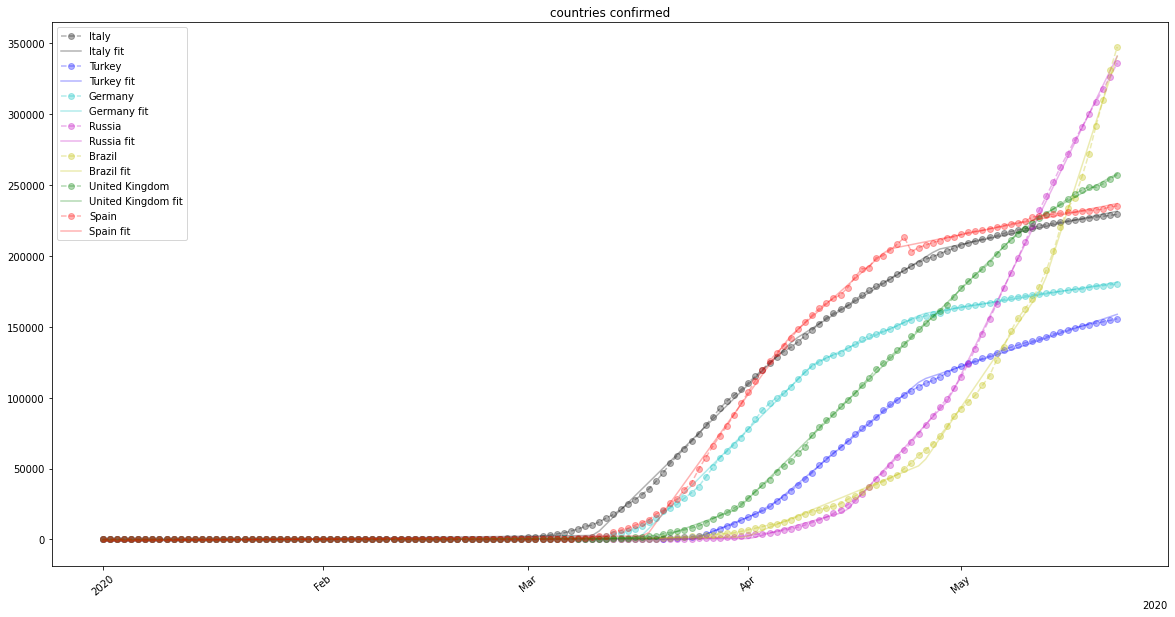

In [10]:
plotCountry(['Italy','Turkey','Germany','Russia','Brazil','United Kingdom','Spain'],'confirmed',firstdate='01/01/20',lastdate='05/22/20')

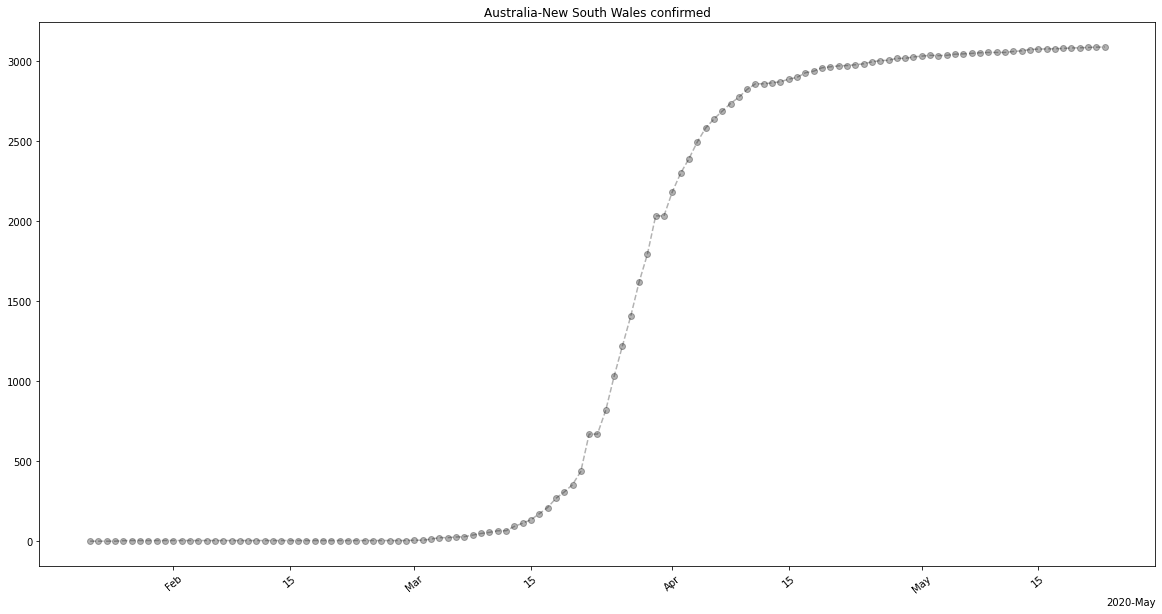

In [11]:
plotCountry(('Australia','New South Wales'),'confirmed','none')
#plotCountry(('Austria',''))

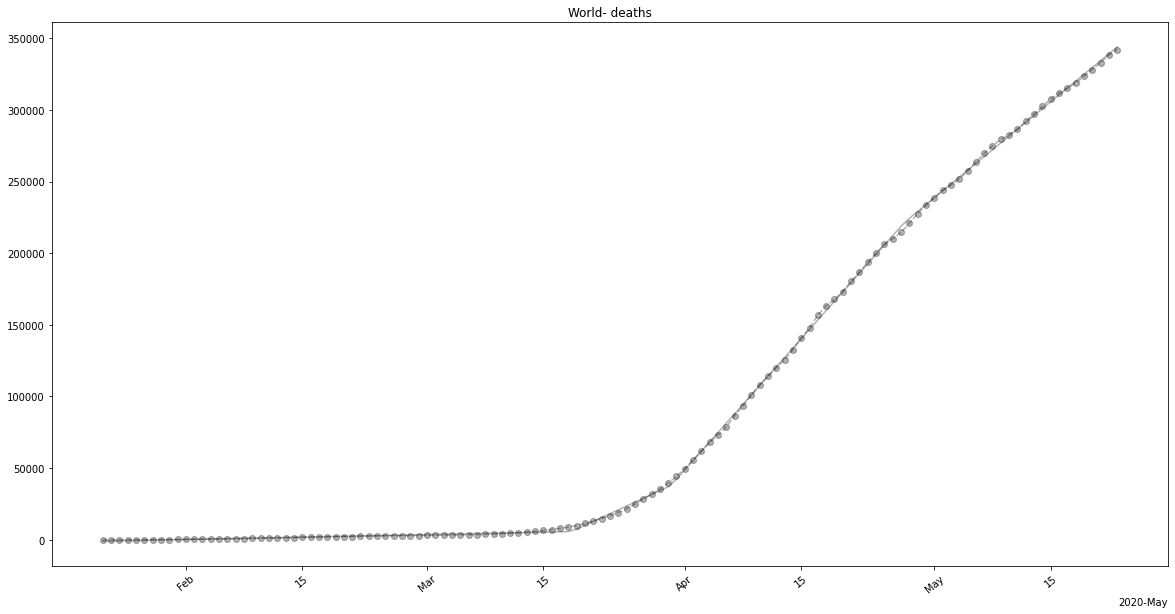

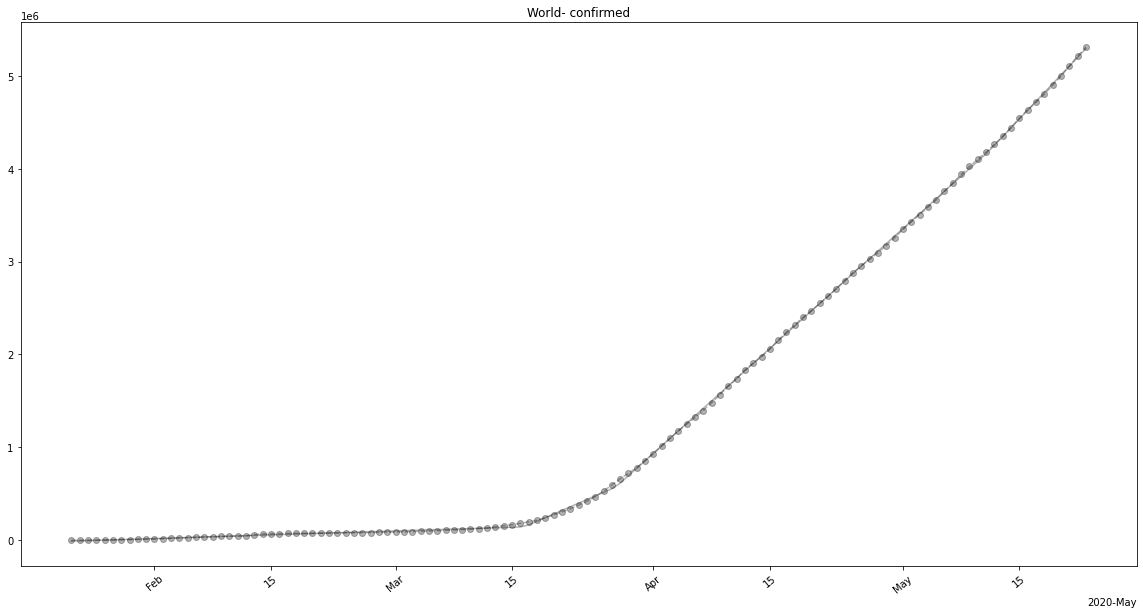

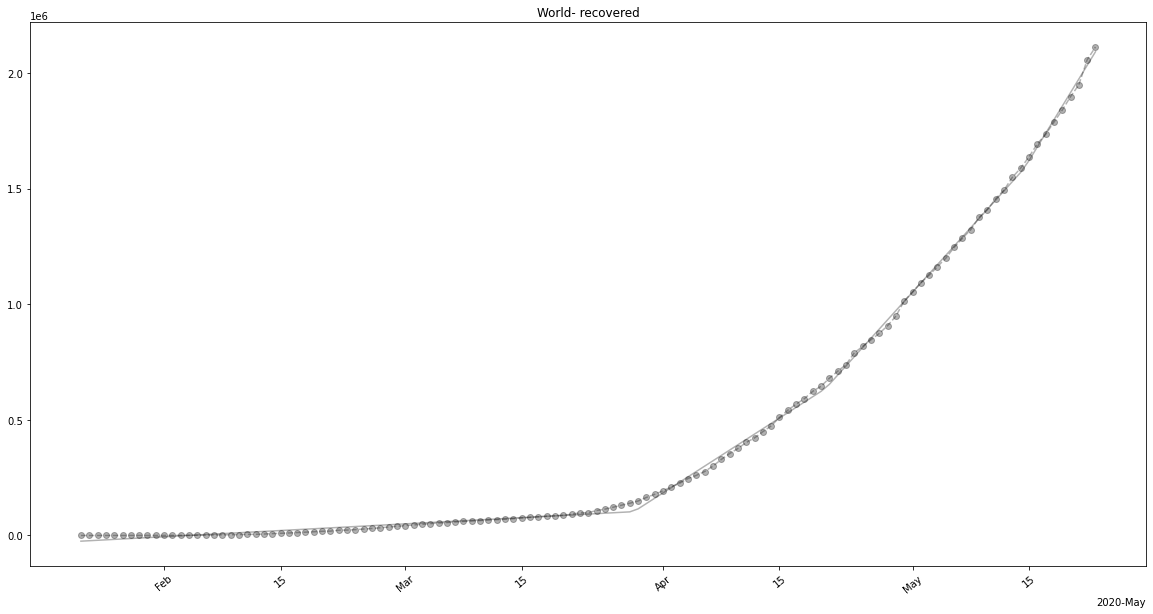

In [12]:
plotCountry('World','deaths')
plotCountry('World','confirmed')
plotCountry('World','recovered')

country not found ('Germany1', '')


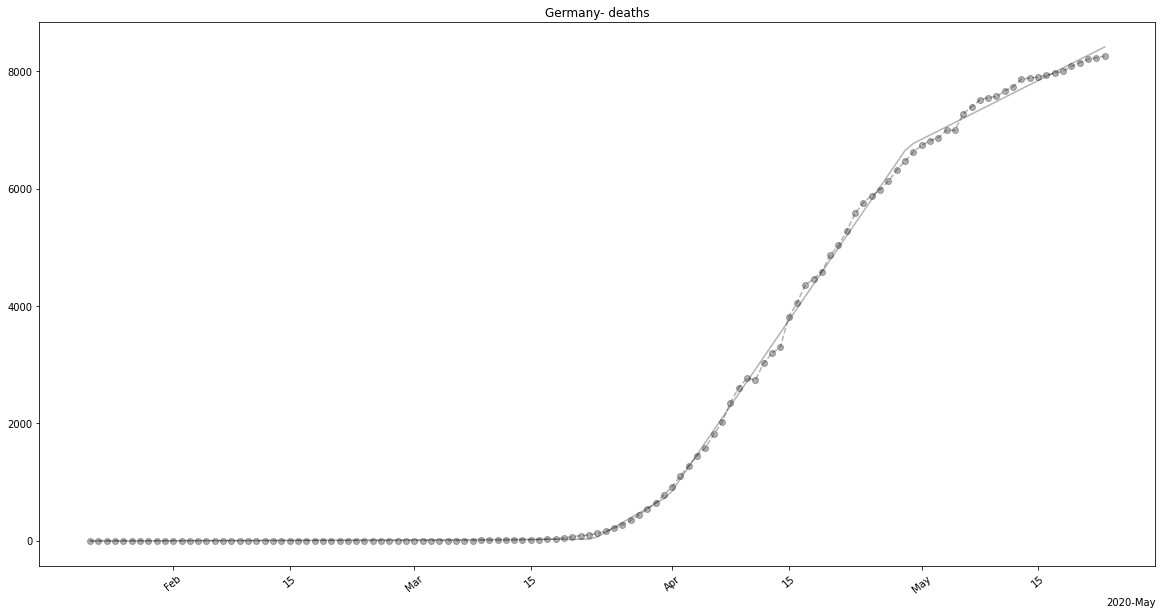

In [13]:
plotCountry(['Germany','Germany1'],'deaths')

number of countries 268


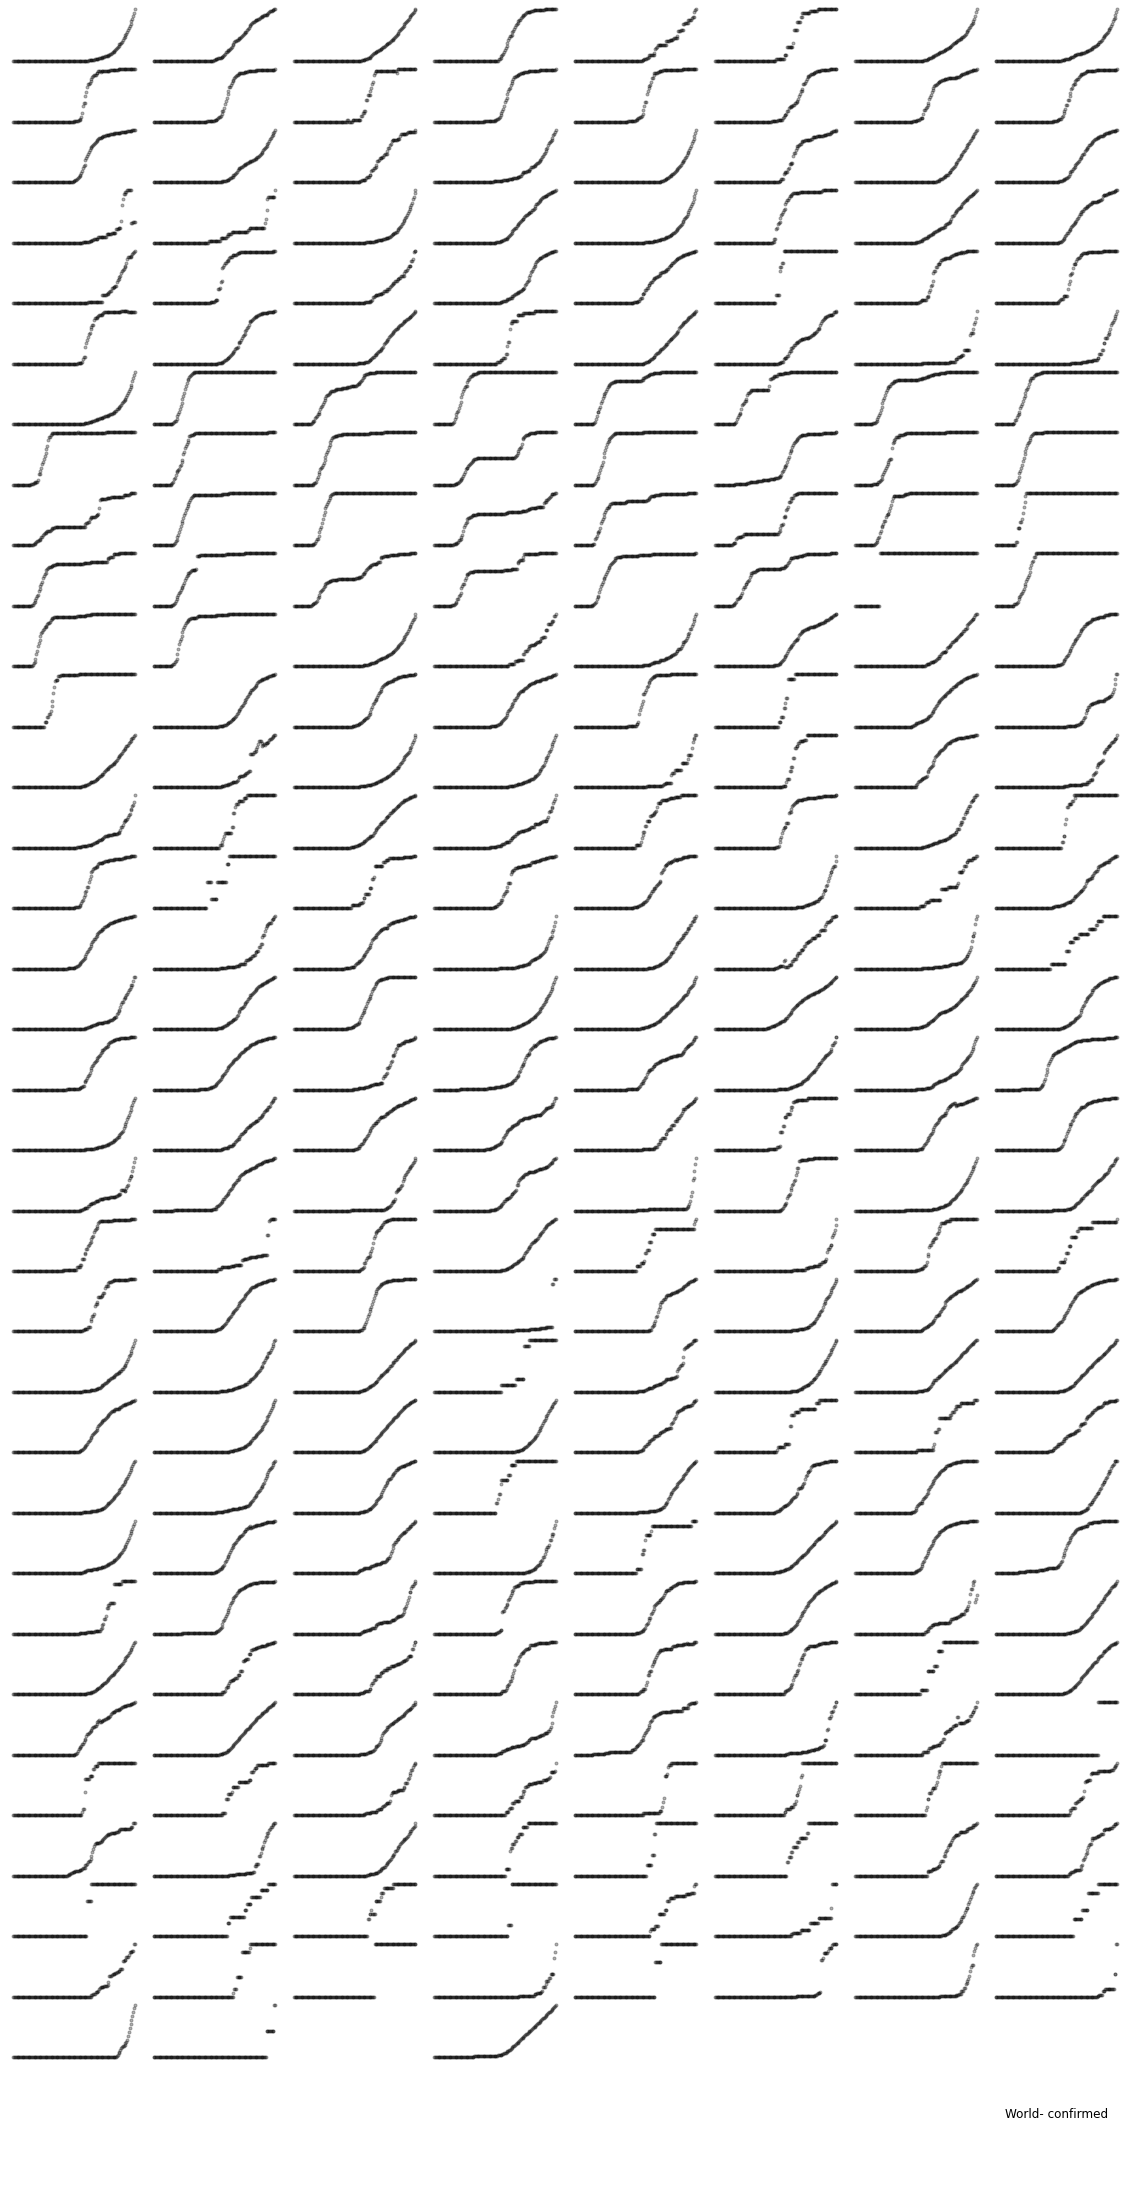

In [14]:
print("number of countries",len(countries))
max_rows=36
max_cols=8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,40))
for idx, country  in enumerate(countries):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    if country != ('d','a'):
        plotCountry(country, datatype='confirmed', fittype=None,ax=axes[row, col],symbol='.',
                   firstdate='01/01/20',lastdate='05/21/20')
for idx in range(len(countries),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

number of countries 268


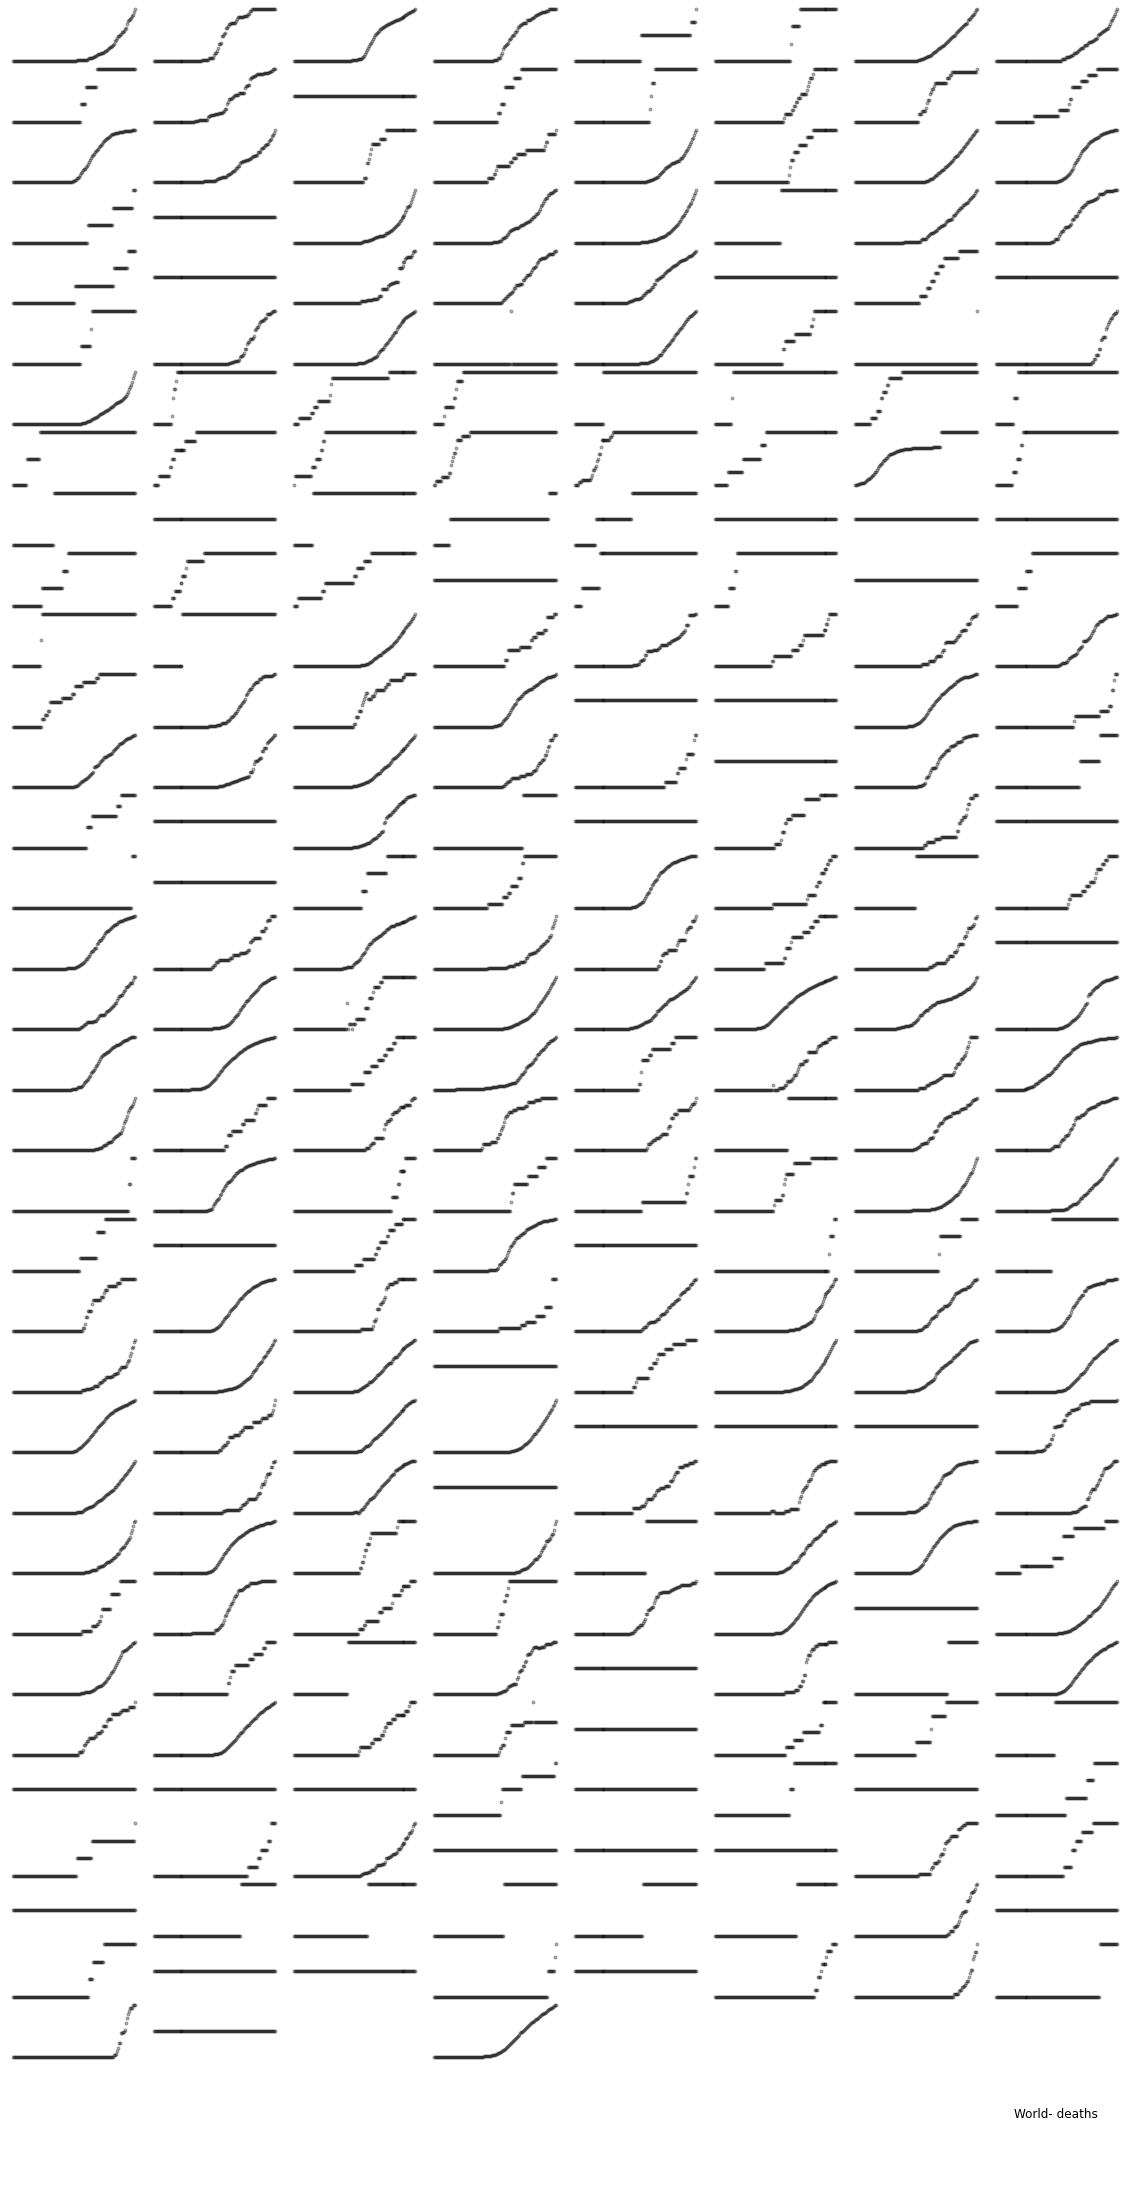

In [15]:
print("number of countries",len(countries))
max_rows=36
max_cols=8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,40))
for idx, country  in enumerate(countries):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    if country != ('d','a'):
        plotCountry(country, datatype='deaths', fittype=None,ax=axes[row, col],symbol='.')
for idx in range(len(countries),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

### Check daily figures with owid data

In [45]:
def plotDaily(country_s, datatype):
    countries = []
    if isinstance(country_s,list):
        for country in country_s:
            if isinstance(country,str):
                country = (country,'')
            countries.append(country)
    elif isinstance(country_s,str):
        countries = [(country_s,'')]
    else:
        countries = [country_s]
            
    popkeyed = covid_ts[datatype]
    dates = popkeyed['dates']
    fmt = '%m/%d/%y'
    xx = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    day0 = datetime.datetime.strptime(dates[0],fmt)
    xxi = [Float((datetime.datetime.strptime(dd,fmt)-day0).days) for dd in dates ]
    # print(xxi)
    # locator = mdates.MonthLocator()
    locator = mdates.AutoDateLocator(minticks=5, maxticks=13)
    formatter= mdates.ConciseDateFormatter(locator)
    
    fig,ax = plt.subplots(1,1,figsize=(20,10))      
    colors =  ['k', 'b', 'c', 'm', 'y', 'g', 'r']
    i = 0
    for country in countries:
            yy = popkeyed[country]
            yyf = [Float(y) for y in yy]
            yyd = [0]*len(yyf)
            yyd[0] = yyf[0]
            for j in range(1,len(yyf)):
                yyd[j] = yyf[j]-yyf[j-1]
            ax.step(xx,yyd,label = country[0])
            # ax.plot(xx, yyd, color = colors[i], alpha=1, label = country[0])

            i = i+1

    #ax.plot(xx, yy, 'o--', color='black', alpha=0.3)
    
    
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
    for tick in ax.get_xticklabels():
        tick.set_rotation(40)
    if len(countries) == 1:
        plt.title(country[0]+'-'+country[1]+' '+datatype)
    else:
        plt.legend(loc="upper left")
        plt.title('countries '+datatype)

**Problem??  these curves don't look anything like daily death curves for OWID/Oxford data**

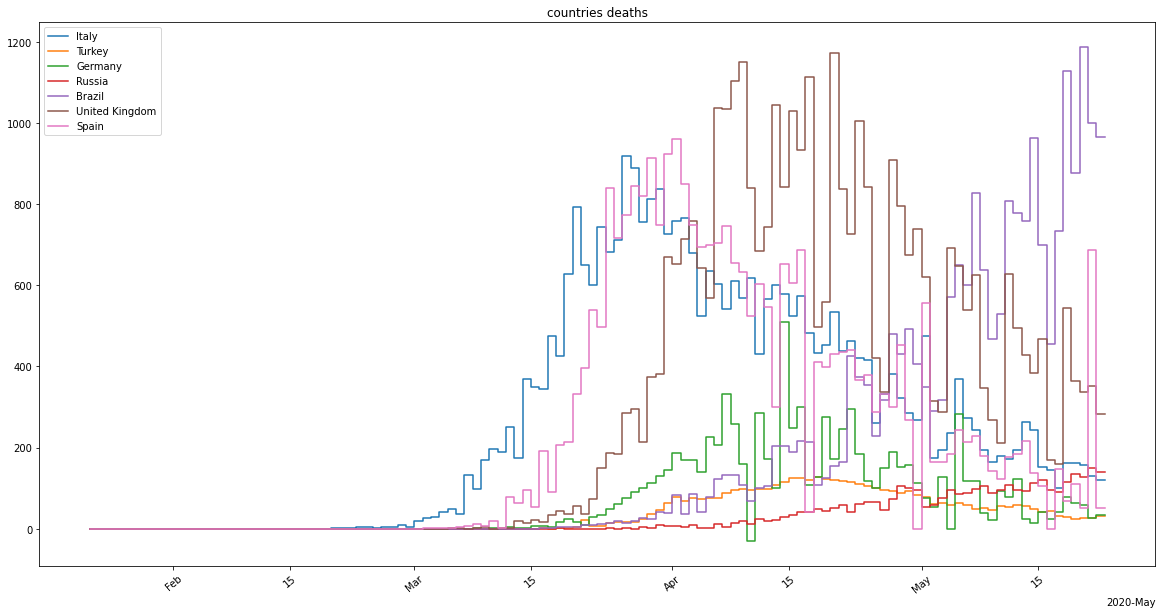

In [46]:
plotDaily(['Italy','Turkey','Germany','Russia','Brazil','United Kingdom','Spain'],'deaths')

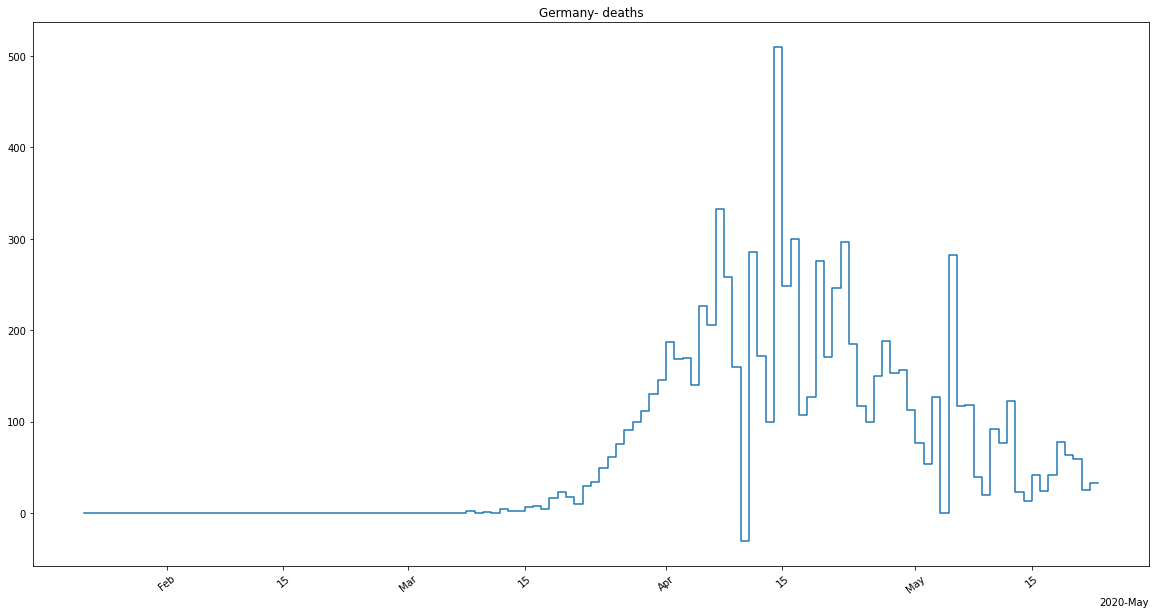

In [40]:
plotDaily(['Germany'],'deaths')

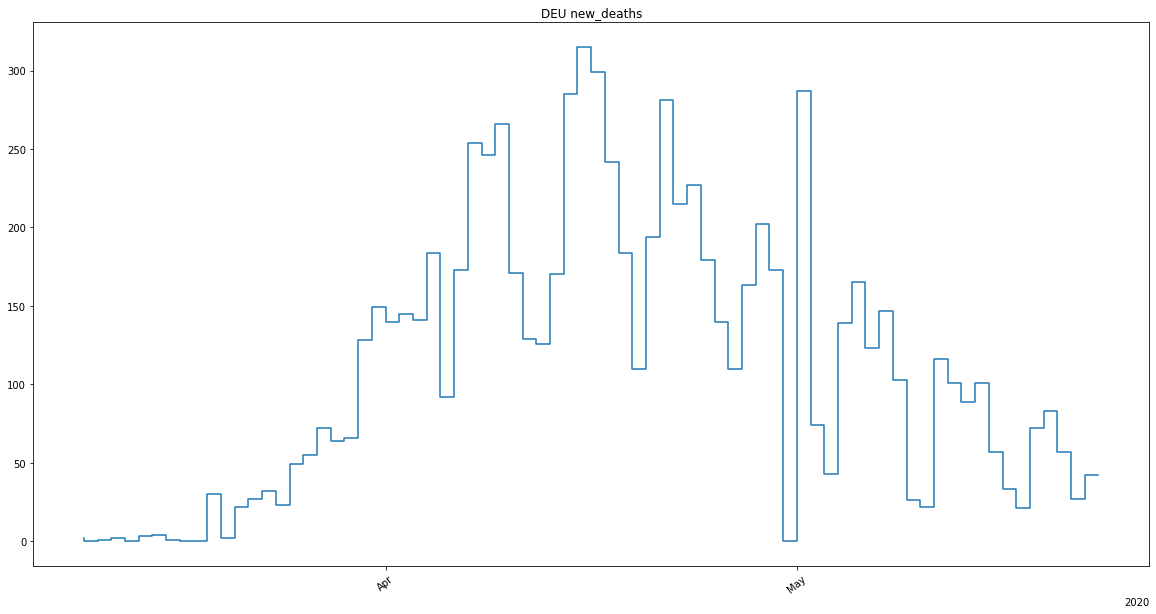

In [50]:
plotTarget('DEU') # from OWID data, with shifted start

## OWID data

In [27]:
owid_file = '../covid-19-owid/public/data/owid-covid-data.csv'
dat = []
with open(owid_file,'r',newline='') as fp:
    myreader = csv.DictReader(fp,delimiter=',')
#    rows = list(itertools.islice(myreader,4))
    for row in myreader:
        dat.append(row)

In [28]:
dat[0].keys()

odict_keys(['iso_code', 'location', 'date', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'total_cases_per_million', 'new_cases_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units', 'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cvd_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_100k'])

In [29]:
set([(d['iso_code'],d['location']) for d in dat])

{('', 'International'),
 ('ABW', 'Aruba'),
 ('AFG', 'Afghanistan'),
 ('AGO', 'Angola'),
 ('AIA', 'Anguilla'),
 ('ALB', 'Albania'),
 ('AND', 'Andorra'),
 ('ARE', 'United Arab Emirates'),
 ('ARG', 'Argentina'),
 ('ARM', 'Armenia'),
 ('ATG', 'Antigua and Barbuda'),
 ('AUS', 'Australia'),
 ('AUT', 'Austria'),
 ('AZE', 'Azerbaijan'),
 ('BDI', 'Burundi'),
 ('BEL', 'Belgium'),
 ('BEN', 'Benin'),
 ('BES', 'Bonaire Sint Eustatius and Saba'),
 ('BFA', 'Burkina Faso'),
 ('BGD', 'Bangladesh'),
 ('BGR', 'Bulgaria'),
 ('BHR', 'Bahrain'),
 ('BHS', 'Bahamas'),
 ('BIH', 'Bosnia and Herzegovina'),
 ('BLR', 'Belarus'),
 ('BLZ', 'Belize'),
 ('BMU', 'Bermuda'),
 ('BOL', 'Bolivia'),
 ('BRA', 'Brazil'),
 ('BRB', 'Barbados'),
 ('BRN', 'Brunei'),
 ('BTN', 'Bhutan'),
 ('BWA', 'Botswana'),
 ('CAF', 'Central African Republic'),
 ('CAN', 'Canada'),
 ('CHE', 'Switzerland'),
 ('CHL', 'Chile'),
 ('CHN', 'China'),
 ('CIV', "Cote d'Ivoire"),
 ('CMR', 'Cameroon'),
 ('COD', 'Democratic Republic of Congo'),
 ('COG', 'Cong

In [30]:
countries = list(set([dd['iso_code'] for dd in dat]))

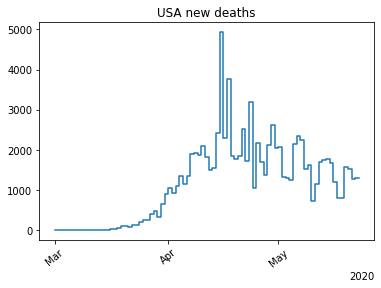

In [31]:
deathUSA = [(dd['date'],dd['new_deaths']) for dd in dat if dd['iso_code']=='USA']

fmt = '%Y-%m-%d'
xx = [datetime.datetime.strptime(dd[0],fmt) for dd in deathUSA if int(dd[1])>0 ]
yy = [int(dd[1]) for dd in deathUSA if int(dd[1])>0 ]

locator = mdates.MonthLocator()
formatter= mdates.ConciseDateFormatter(locator)

fig,ax = plt.subplots(1,1)
ax.step(xx,yy)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
for tick in ax.get_xticklabels():
    tick.set_rotation(40)
plt.title('USA new deaths')
plt.show()

In [48]:
def plotTarget(iso,targ='new_deaths'):
    datt = [(dd['date'],dd[targ]) for dd in dat if dd['iso_code']==iso]
    deathstr = 'death'+iso
    fmt = '%Y-%m-%d'
    
    start=False
    xx = [] ; yy = []
    for i in range(len(datt)):
        dd = datt[i]
        if float(dd[1]) == 0:
            if start==False:
                continue
            else:
                pass
        else:
            if start==False:
                start=True
        if start:
            xx.append(datetime.datetime.strptime(dd[0],fmt))
            yy.append(float(dd[1]))
        
#    xx = [datetime.datetime.strptime(dd[0],fmt) for dd in datt if float(dd[1])>0 ]
#    yy = [float(dd[1]) for dd in datt if int(dd[1])>0 ]

    locator = mdates.MonthLocator()
    formatter= mdates.ConciseDateFormatter(locator)

    register_matplotlib_converters() # pandas made me do it
    fig,ax = plt.subplots(1,1,figsize=(20,10))
    ax.step(xx,yy)
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
    for tick in ax.get_xticklabels():
        tick.set_rotation(40)
        plt.title(iso+' '+targ)
    plt.show()

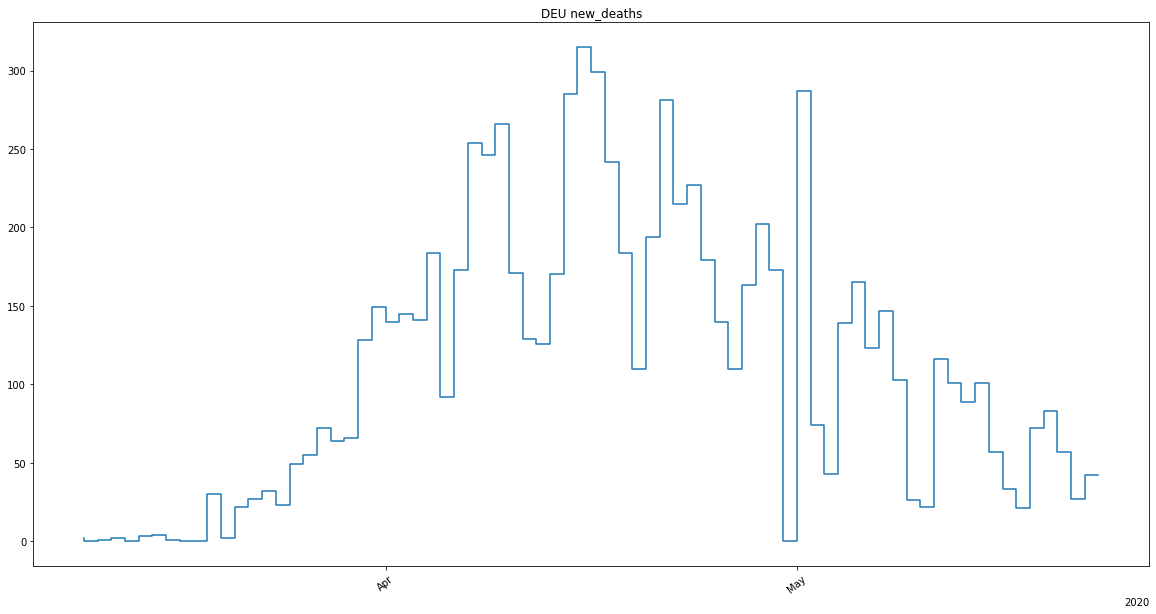

In [49]:
plotTarget('DEU')

In [ ]:
plotTarget('DEU','new_cases')

In [ ]:
plotTarget('USA','new_cases')

In [ ]:
plotTarget('FRA','new_cases')

In [ ]:
plotTarget('SWE','new_cases')

In [ ]:
plotTarget('SWE','new_deaths')

In [ ]:
plotTarget('BRA','new_deaths')

## Oxford data

In [ ]:
owid_file = '../covid-policy-tracker/data/OxCGRT_latest.csv'
oxdat = []
with open(owid_file,'r',newline='') as fp:
    myreader = csv.DictReader(fp,delimiter=',')
#    rows = list(itertools.islice(myreader,4))
    for row in myreader:
        oxdat.append(row)
    

In [ ]:
oxdat[0].keys()

In [ ]:
countries = list(set([(dd['CountryName'],dd['CountryCode']) for dd in oxdat]))

In [ ]:
[countries[i] for i in range(10)]

In [ ]:
dates = np.sort(list([dd['Date'] for dd in oxdat]))
dates_uniq = np.unique(dates)
dates_uniq

In [ ]:
foo = [(dd['Date'],dd['C1_School closing'],dd['C1_Flag']) for dd in oxdat if dd['CountryCode']=='USA']

In [ ]:
xx = foo[0:10]
print(xx)
xx=foo[-10:]
print(xx)

In [ ]:
foo = [(dd['Date'],dd['C1_School closing'],dd['C1_Flag']) 
       for dd in oxdat if dd['CountryCode']=='USA']

fmt = '%Y%m%d'
first = 31+22-1
xx = [datetime.datetime.strptime(dd[0],fmt) for dd in foo][first:]
yy = []
for dd in foo[first:]:
    try:
        yy.append(float(dd[1]))
    except:
        yy.append(float('NaN'))


locator = mdates.MonthLocator()
formatter= mdates.ConciseDateFormatter(locator)

fig,ax = plt.subplots(1,1)
ax.step(xx,yy)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
for tick in ax.get_xticklabels():
    tick.set_rotation(40)
plt.title('USA')
plt.show()

Note:  no wildcard data:

In [ ]:
foo = [(dd['Date'],dd['CountryCode'],dd['M1_Wildcard']) 
       for dd in oxdat if dd['M1_Wildcard'] != '']



In [ ]:
foo


Notes:  
* first version of `datcodes` leaves out all flags (general vs. targeted implementation)
* 2nd version leaves out all variables measured in dollars

In [ ]:
datcodes = ['C1_School closing', 'C2_Workplace closing', 
            'C3_Cancel public events', 'C4_Restrictions on gatherings', 
            'C5_Close public transport', 'C6_Stay at home requirements', 
            'C7_Restrictions on internal movement', 'C8_International travel controls', 
            'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures', 
            'E4_International support', 'H1_Public information campaigns', 
            'H2_Testing policy', 'H3_Contact tracing', 
            'H4_Emergency investment in healthcare', 'H5_Investment in vaccines']

datcodes = ['C1_School closing', 'C2_Workplace closing', 
            'C3_Cancel public events', 'C4_Restrictions on gatherings', 
            'C5_Close public transport', 'C6_Stay at home requirements', 
            'C7_Restrictions on internal movement', 'C8_International travel controls', 
            'E1_Income support', 'E2_Debt/contract relief', 
            'H1_Public information campaigns', 
            'H2_Testing policy', 'H3_Contact tracing']



In [ ]:
countrycodes = list(set([dd['CountryCode'] for dd in oxdat]))
len(countrycodes)

In [ ]:
def Float(x):
    try:
        rtn = float(x)
    except:
        rtn = float('NaN')
    return rtn


In [ ]:
def get_codedat(countrycode='USA'):
    codedat = []
    foo = [[dd['Date']]+ [Float(dd[c]) for c in datcodes]
           for dd in oxdat if dd['CountryCode']==countrycode]
    return foo
    


In [ ]:
get_codedat()

### Response policy maps

* time along x axis 
* NaN same color as max value (typically 4)
* 12 rows for presence of 12 factors.  cf oxford codebook.md in ../covid-policy-tracker/documentation/.

In [ ]:
# for comaptibility with JHU data set first elt as 22nd Feb 2020
# assuming Oxford records start with Jan 1st 2020
first = 31+22-1

In [ ]:
foo = get_codedat('DEU')
foo = [f[1:] for f in foo]
plt.imshow(np.transpose(foo),cmap='hot',aspect='auto');
plt.title('DEU')


In [ ]:
foo = get_codedat('USA')[first:]
foo = [f[1:] for f in foo]
plt.imshow(np.transpose(foo),cmap='hot',aspect='auto');
plt.title("USA")

In [ ]:
foo = get_codedat('KOR')
foo = [f[1:] for f in foo]
plt.imshow(np.transpose(foo),cmap='hot',aspect='auto');

In [ ]:
foo = get_codedat('SWE')
foo = [f[1:] for f in foo]
plt.imshow(np.transpose(foo),cmap='hot',aspect='auto');

In [ ]:
print("number of countries",len(countrycodes))
max_rows=21
max_cols=8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,40))
for idx, countrycode  in enumerate(countrycodes):
    foo = get_codedat(countrycode)
    foo = [f[1:] for f in foo]
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    axes[row, col].imshow(np.transpose(foo),cmap='hot',aspect='auto',interpolation='none');
for idx in range(len(countrycodes),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

In [ ]:
# print country data and corresponding JHU confirmed cases if available on same timescale
# almost finished
print("number of countries",len(countrycodes))
max_rows=21
max_cols=8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,40))
for idx, countrycode  in enumerate(countrycodes):
    foo = get_codedat(countrycode)
    foo = [f[1:] for f in foo]
    
    countrynames = [dd['CountryName'] for dd in oxdat if dd['CountryCode']==countrycode]
    countryname = countrynames[0]
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    axes[row, col].imshow(np.transpose(foo),cmap='hot',aspect='auto',interpolation='none')
    plotCountry(countryname, datatype='confirmed', fittype=None,ax=axes[row, col],symbol='.',
                   firstdate='01/01/20',lastdate='05/21/20',xxx=range(len(foo[0])))
for idx in range(len(countrycodes),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

In [ ]:
foo = get_codedat('FRA')
fmt = '%Y%m%d'

locator = mdates.MonthLocator()
formatter= mdates.ConciseDateFormatter(locator)
xx =[datetime.datetime.strptime(dd[0],fmt) for dd in foo]
foo = [f[1:] for f in foo]

register_matplotlib_converters() # pandas made me do it
fig,ax = plt.subplots(1,1)
ax.imshow(np.transpose(foo),cmap='hot',aspect='auto');
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
for tick in ax.get_xticklabels():
    tick.set_rotation(40)

plt.show()